# Improved Mortality of Patients Prediction using Clinical Notes

In [3]:
import csv
import string
import re
import sys
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
import lda
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt

In [4]:
csv.field_size_limit(2147483647)
stop=stopwords.words('english')
punc=string.punctuation+string.digits
regex = re.compile('[%s]' % re.escape(punc))

## Utility Function

In [139]:
def getKey(item):
    return item[1]

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

def plot_roc(test_y,predict):
    fpr, tpr, _ = metrics.roc_curve(test_y, predict)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Parse Clinical Notes and Shuffle to selected words

In [6]:
with open('E:/A+GTCLASS/CSE8803/paper/code/data/note_final.csv', 'rb') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    i=0
    doc_all=[]
    row_num=[]
    for row in spamreader:
        document=[]
        doc=row[1].lower().replace('\n','').split('&&&&&&&&&&')
        if i!=0:
            str1=''
            for j in doc:
                j=regex.sub('',j).replace('  ','')                
                j=' '.join(h for h in j.split(' ') if h not in stop)
                document.append(j)
                if str1!='':
                    str1=str1+' '+j
                else:
                    str1=j
            if len(str1.split(' '))>100:
                vectorizer = CountVectorizer()
                x=vectorizer.fit_transform(document).toarray()
                word=np.sum(x,axis=0)
                feature=vectorizer.get_feature_names()
                rank=sorted(zip(feature,word),key=getKey,reverse=True)
                if len(rank)>=100:
                    selected=[j[0] for j in rank[:100]]
                else:
                    selected=[j[0] for j in rank]
                s=' '.join(h for h in str1.split(' ') if h in selected)
                doc_all.append(s)
                row_num.append(int(row[0]))
        i=i+1

## TF-IDF

In [7]:
count_vect = TfidfVectorizer(min_df=1)
X_train_counts = count_vect.fit_transform(doc_all)
feature_all=count_vect.get_feature_names()

In [97]:
from scipy.io import mmwrite
mmwrite('E:/A+GTCLASS/CSE8803/paper/code/data/csr_matrix.mtx', X_train_counts)

## Join dataset together

In [8]:
df_tfidf=pd.DataFrame(zip(row_num,range(X_train_counts.shape[0])),columns=["subject_id","vocab"])
df_tfidf['subject_id']=df_tfidf['subject_id'].astype(int)
df_tfidf.head()

,subject_id,vocab
0,3,0
1,4,1
2,6,2
3,9,3
4,11,4


In [102]:
df_fea=pd.DataFrame(zip(range(len(feature_all)),feature_all),columns=["word_id","word"])
df_fea.to_csv('E:/A+GTCLASS/CSE8803/paper/code/data/lookupword.csv',index=False)

In [99]:
df_tfidf.to_csv('E:/A+GTCLASS/CSE8803/paper/code/data/lookupdoc.csv',index=False)

In [47]:
df_heart=pd.read_csv('E:/A+GTCLASS/CSE8803/paper/code/data/patients_tab.csv')#patient table
df_heart['subject_id']=df_heart['subject_id'].astype(int)
df_heart.set_value(pd.isnull(df_heart["dod_hosp"]), 'dead_in_hospital', 0)
df_heart.set_value(pd.notnull(df_heart["dod_hosp"]), 'dead_in_hospital', 1)
df_heart.head()

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,dead_in_hospital
0,612,646,1,2128-01-05 00:00:00,NaN,NaN,NaN,0,0
1,613,647,1,2106-03-24 00:00:00,NaN,NaN,NaN,0,0
2,614,648,1,2139-07-13 00:00:00,NaN,NaN,NaN,0,0
3,615,649,1,2177-06-23 00:00:00,NaN,NaN,NaN,0,0
4,616,650,1,2051-04-15 00:00:00,2111-12-28 00:00:00,NaN,2111-12-28 00:00:00,1,0


In [48]:
df_merge=df_tfidf.merge(df_heart,on=['subject_id'],how='inner')
df_merge.head()

,subject_id,vocab,row_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,dead_in_hospital
0,3,0,2,1,2025-04-11 00:00:00,2102-06-14 00:00:00,NaN,2102-06-14 00:00:00,1,0
1,4,1,3,0,2143-05-12 00:00:00,NaN,NaN,NaN,0,0
2,6,2,5,0,2109-06-21 00:00:00,NaN,NaN,NaN,0,0
3,9,3,8,1,2108-01-26 00:00:00,2149-11-14 00:00:00,2149-11-14 00:00:00,2149-11-14 00:00:00,1,1
4,11,4,10,0,2128-02-22 00:00:00,2178-11-14 00:00:00,NaN,2178-11-14 00:00:00,1,0


In [11]:
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn.cross_validation import KFold

## dead after discharging from hospital using only text data, Naive Bayes

In [20]:
auc,sco=[],[]
kf = KFold(df_merge.shape[0], n_folds=10,shuffle=True)
for train, test in kf:
    training_set,testing_set=df_merge.iloc[train],df_merge.iloc[test]
    training_x,training_y=X_train_counts[list(training_set['vocab']),],training_set['expire_flag'].as_matrix()
    testing_x,testing_y=X_train_counts[list(testing_set['vocab']),],testing_set['expire_flag'].as_matrix()
    clf = MultinomialNB()
    clf.fit(training_x,training_y)
    pre = clf.predict(testing_x)
    score=clf.score(testing_x,testing_y)
    sco.append(score)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc.append(auc_sco)
print np.mean(auc),np.mean(sco)

0.701096812152 0.7333368499


## dead in hospital using only text data, Naive Bayes

In [49]:
auc,sco=[],[]
kf = KFold(df_merge.shape[0], n_folds=10,shuffle=True)
for train, test in kf:
    training_set,testing_set=df_merge.iloc[train],df_merge.iloc[test]
    training_x,training_y=X_train_counts[list(training_set['vocab']),],training_set['dead_in_hospital'].as_matrix()
    testing_x,testing_y=X_train_counts[list(testing_set['vocab']),],testing_set['dead_in_hospital'].as_matrix()
    clf = MultinomialNB()
    clf.fit(training_x,training_y)
    pre = clf.predict(testing_x)
    score=clf.score(testing_x,testing_y)
    sco.append(score)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc.append(auc_sco)
print np.mean(auc),np.mean(sco)

0.527783884605 0.757894741645


In [21]:
print str1

sinus rhythm normal tracing compared previous tracing ofnodiagnostic interim change sinus rhythmnormal tracingcompared previous tracing rate increasedotherwise diagnostic interim change  yo f pod plif l experienced episode respiratory distress floor possibly dropped sats stridorous episode responded racemic epinephrine coughing sputum respiratory distress assessment admitted floor sp episode sob pt calm adm satson o via fm aox back dressing intact jp serosang output two episodes sob arrival without desat vss febrile tolungs bilat clear stridor anxious action pt reassured cpt qhr instructed calm breathe slowly response relaxed andtalked anxiety symptoms improved sats remainplan monitor resp status overnight tx floor respiratory failure acute ardsdoctor last nameassessment vsso sat high toon rano co sobpt co generalized pain back incisionlungs cta bilatpt aox moves extremities bed action pt instructed use chest pt donedilaudid given prn name mdmd orders pain response pt denied sob majori

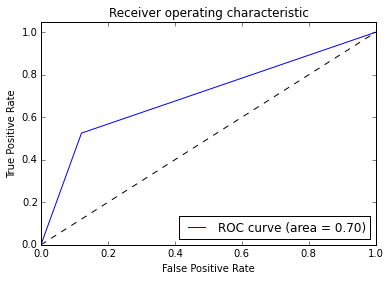

In [25]:
%matplotlib inline
plot_roc(testing_y,pre)

## Dead eventually Using text data only, Random Forest

In [95]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
auc,sco=[],[]
kf = KFold(df_merge.shape[0], n_folds=10,shuffle=True)
for train, test in kf:
    training_set,testing_set=df_merge.iloc[train],df_merge.iloc[test]
    training_x,training_y=X_train_counts[list(training_set['vocab']),],training_set['expire_flag'].as_matrix()
    testing_x,testing_y=X_train_counts[list(testing_set['vocab']),],testing_set['expire_flag'].as_matrix()
    clf=RandomForestClassifier(max_depth=30, n_estimators=10)
    clf.fit(training_x,training_y)
    pre = clf.predict(testing_x)
    score=clf.score(testing_x,testing_y)
    sco.append(score)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc.append(auc_sco)
print np.mean(auc),np.mean(sco)

0.673677488358 0.707746077203


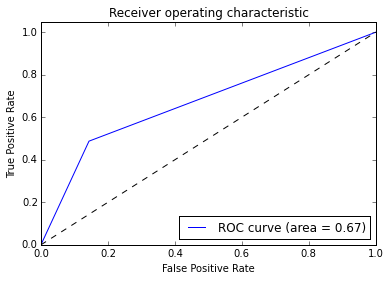

In [96]:
plot_roc(testing_y,pre)

## dead in hopital with only text data, using Random Forest and Gradient Boosting

In [50]:
auc,auc1=[],[]
kf = KFold(df_merge.shape[0], n_folds=10,shuffle=True)
for train, test in kf:
    training_set,testing_set=df_merge.iloc[train],df_merge.iloc[test]
    training_x,training_y=X_train_counts[list(training_set['vocab']),],training_set['dead_in_hospital'].as_matrix()
    testing_x,testing_y=X_train_counts[list(testing_set['vocab']),],testing_set['dead_in_hospital'].as_matrix()
    clf=RandomForestClassifier(max_depth=30, n_estimators=10)
    clf.fit(training_x,training_y)
    pre = clf.predict(testing_x)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc.append(auc_sco)
    clf1=GradientBoostingClassifier(n_estimators=10)
    clf1.fit(training_x,training_y)
    pre1 = clf1.predict(testing_x.toarray())
    auc_sco1=metrics.roc_auc_score(testing_y,pre1)
    auc1.append(auc_sco1)    
print np.mean(auc),np.mean(auc1)

0.568311263809 0.577480406774


## Classify using gradient boosting classifier with only text data

In [99]:
from sklearn.ensemble import GradientBoostingClassifier
auc=[]
kf = KFold(df_merge.shape[0], n_folds=10,shuffle=True)
for train, test in kf:
    training_set,testing_set=df_merge.iloc[train],df_merge.iloc[test]
    training_x,training_y=X_train_counts[list(training_set['vocab']),],training_set['expire_flag'].as_matrix()
    testing_x,testing_y=X_train_counts[list(testing_set['vocab']),],testing_set['expire_flag'].as_matrix()
    clf=GradientBoostingClassifier(n_estimators=10)
    clf.fit(training_x,training_y)
    pre = clf.predict(testing_x.toarray())
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc.append(auc_sco)
print np.mean(auc)

0.63543377657


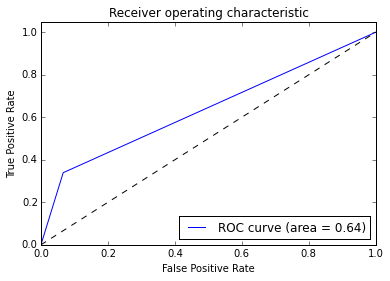

In [100]:
plot_roc(testing_y,pre)

## Topic Modeling using NMF and LDA

In [132]:
nmf_model = NMF(n_components=50, random_state=1, alpha=.1, l1_ratio=.5)
nmf_model.fit(X_train_counts)
print_top_words(nmf_model, feature_all, 10)

Topic #0:
right pleural lung lobe chest left effusion lower upper small
Topic #1:
thick trach yellow secretions pt vent resp remains coarse via
Topic #2:
normal valve size wall aortic mitral leaflets systolic function chamber
Topic #3:
ml assessed history pulse icu patient po total review mgdl
Topic #4:
subdural hematoma sdh head evacuation midline frontal shift ct wo
Topic #5:
cabg coronary artery bypass chest graft diseasecoronary pneumothorax post pleural
Topic #6:
dissection cta aortic aorta wwo crecons aneurysm thoracic aaa repair
Topic #7:
neo good clear pain wean sbp cabg given per bs
Topic #8:
fracture fractures trauma rib fall injury ct cervical head sp
Topic #9:
liver hepatic transplant portal biopsy patent lesions us flow normal
Topic #10:
portal vein tips hepatic flow cirrhosis patent main liver thrombosis
Topic #11:
metastatic cancer breast lesions lesion cell ca disease new melanoma
Topic #12:
spine spinal cervical fusion cord lumbar disc thoracic vertebral posterior
Topi

In [35]:
nmf_model.components_.shape

(50L, 53741L)

In [133]:
nmf_topic_vec=X_train_counts.dot(nmf_model.components_.T)
nmf_topic_vec.shape

(37748L, 50L)

In [12]:
count_vect_real = CountVectorizer()
X_counts = count_vect_real.fit_transform(doc_all)
feature=count_vect_real.get_feature_names()

In [128]:
X_counts[37747,43770]

5

In [104]:
mmwrite('E:/A+GTCLASS/CSE8803/paper/code/data/csr_matrix_count.mtx', X_counts)

In [105]:
df_fea1=pd.DataFrame(zip(range(len(feature)),feature),columns=["word_id","word"])
df_fea1.to_csv('E:/A+GTCLASS/CSE8803/paper/code/data/lookupwordcount.csv',index=False)

In [13]:
lda = lda.LDA(n_topics=50, n_iter=150, random_state=1)
lda.fit(X_counts)
doc_topic=lda.doc_topic_
print_top_words(lda, feature, 10)

Topic #0:
pt name placed last noted iv given per cont today
Topic #1:
right ct left lobe chest upper prior number images within
Topic #2:
pt thick vent remains resp name secretions yellow cont bs
Topic #3:
pain old left right chest pt report medical name normal
Topic #4:
ml assessed icu pulse history total assessment po mgdl patient
Topic #5:
paced pacer vt av rhythm pacemaker ventricular icd sp block
Topic #6:
right tube left chest report number reason old medical radiologyreason
Topic #7:
ca cancer metastatic lung right cell left breast mass patient
Topic #8:
aortic aorta dissection chest repair cta thoracic aaa ascending aneurysm
Topic #9:
intubated pt gtt propofol increased fentanyl remains vent wean sedation
Topic #10:
liver cirrhosis ascites hepatic name tips lactulose transplant paracentesis portal
Topic #11:
pleural effusion chest right left pericardial effusions fluid small bilateral
Topic #12:
valve normal aortic left ventricular mild seen mitral mildly right
Topic #13:
fract

In [156]:
doc_topic.shape

(37748L, 50L)

In [14]:
df_topic=pd.DataFrame(zip(row_num,range(doc_topic.shape[0])),columns=["subject_id","topic"])
df_topic['subject_id']=df_topic['subject_id'].astype(int)
df_topic.head()

,subject_id,topic
0,3,0
1,4,1
2,6,2
3,9,3
4,11,4


## Join data with topic features

In [15]:
table_sapii=pd.read_csv('E:/A+GTCLASS/CSE8803/paper/code/data/saspii_edit.csv')#sapii table
table_sapii['subject_id']=table_sapii['subject_id'].astype(int)
df_topic_merge=df_topic.merge(table_sapii,on=['subject_id'],how='inner')
df_topic_merge.head()

,subject_id,topic,hadm_id,icustay_id,sapsii,sapsii_prob,age_score,hr_score,sysbp_score,temp_score,...,uo_score,bun_score,wbc_score,potassium_score,sodium_score,bicarbonate_score,bilirubin_score,gcs_score,comorbidity_score,admissiontype_score
0,3,0,145834,211552,73,0.870860,16,7,13,0,...,11,6,3,3,1,5,0,0,0,8
1,4,1,185777,294638,35,0.166523,7,0,5,0,...,0,0,0,0,0,0,0,0,17,6
2,6,2,107064,228232,24,0.058153,12,0,0,0,...,0,6,0,3,0,3,0,0,0,0
3,9,3,150750,220597,22,0.046739,7,0,2,0,...,4,0,0,3,0,0,0,0,0,6
4,11,4,194540,229441,25,0.064649,7,0,5,0,...,0,0,0,0,0,0,NaN,5,0,8


In [51]:
df_all=df_topic_merge.merge(df_heart,on=['subject_id'],how='inner')
df_all.head()

,subject_id,topic,hadm_id,icustay_id,sapsii,sapsii_prob,age_score,hr_score,sysbp_score,temp_score,...,comorbidity_score,admissiontype_score,row_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,dead_in_hospital
0,3,0,145834,211552,73,0.870860,16,7,13,0,...,0,8,2,1,2025-04-11 00:00:00,2102-06-14 00:00:00,NaN,2102-06-14 00:00:00,1,0
1,4,1,185777,294638,35,0.166523,7,0,5,0,...,17,6,3,0,2143-05-12 00:00:00,NaN,NaN,NaN,0,0
2,6,2,107064,228232,24,0.058153,12,0,0,0,...,0,0,5,0,2109-06-21 00:00:00,NaN,NaN,NaN,0,0
3,9,3,150750,220597,22,0.046739,7,0,2,0,...,0,6,8,1,2108-01-26 00:00:00,2149-11-14 00:00:00,2149-11-14 00:00:00,2149-11-14 00:00:00,1,1
4,11,4,194540,229441,25,0.064649,7,0,5,0,...,0,8,10,0,2128-02-22 00:00:00,2178-11-14 00:00:00,NaN,2178-11-14 00:00:00,1,0


In [112]:
df_count_admin=pd.read_csv('E:/A+GTCLASS/CSE8803/paper/code/data/count_admin.csv')#new var
df_count_admin['subject_id']=df_count_admin['subject_id'].astype(int)
df_count_admin.head()

,subject_id,count
0,10295,1
1,11890,1
2,22262,1
3,6122,1
4,65130,1


In [113]:
df_count_admin_stay=pd.read_csv('E:/A+GTCLASS/CSE8803/paper/code/data/count_admin_stay.csv')#new var 2
df_count_admin_stay['subject_id']=df_count_admin_stay['subject_id'].astype(int)
df_count_admin_stay.head()

,subject_id,avg
0,2,0.0918
1,3,6.0646
2,4,1.6785
3,5,0.0844
4,6,3.6729


In [114]:
df_all_new1=df_all.merge(df_count_admin,on=['subject_id'],how='inner')
df_all_new2=df_all_new1.merge(df_count_admin_stay,on=['subject_id'],how='inner')
df_all_new2.head()

,subject_id,topic,hadm_id,icustay_id,sapsii,sapsii_prob,age_score,hr_score,sysbp_score,temp_score,...,row_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,dead_in_hospital,count,avg
0,3,0,145834,211552,73,0.870860,16,7,13,0,...,2,1,2025-04-11 00:00:00,2102-06-14 00:00:00,NaN,2102-06-14 00:00:00,1,0,1,6.0646
1,4,1,185777,294638,35,0.166523,7,0,5,0,...,3,0,2143-05-12 00:00:00,NaN,NaN,NaN,0,0,1,1.6785
2,6,2,107064,228232,24,0.058153,12,0,0,0,...,5,0,2109-06-21 00:00:00,NaN,NaN,NaN,0,0,1,3.6729
3,9,3,150750,220597,22,0.046739,7,0,2,0,...,8,1,2108-01-26 00:00:00,2149-11-14 00:00:00,2149-11-14 00:00:00,2149-11-14 00:00:00,1,1,1,5.3231
4,11,4,194540,229441,25,0.064649,7,0,5,0,...,10,0,2128-02-22 00:00:00,2178-11-14 00:00:00,NaN,2178-11-14 00:00:00,1,0,1,1.5844


In [135]:
df_all_var=df_all_new2[['subject_id','sapsii','gender','age_score','sapsii_prob','hr_score','sysbp_score','temp_score','uo_score','bun_score'\
                   ,'wbc_score','potassium_score','sodium_score','bicarbonate_score','gcs_score','comorbidity_score'\
                   ,'admissiontype_score','dead_in_hospital','expire_flag','count','avg','topic']]
df_all_var=df_all_var[pd.notnull(df_all_var).all(axis=1)]
df_all_var.head()

,subject_id,sapsii,gender,age_score,sapsii_prob,hr_score,sysbp_score,temp_score,uo_score,bun_score,...,sodium_score,bicarbonate_score,gcs_score,comorbidity_score,admissiontype_score,dead_in_hospital,expire_flag,count,avg,topic
0,3,73,1,16,0.870860,7,13,0,11,6,...,1,5,0,0,8,0,1,1,6.0646,0
1,4,35,0,7,0.166523,0,5,0,0,0,...,0,0,0,17,6,0,0,1,1.6785,1
2,6,24,0,12,0.058153,0,0,0,0,6,...,0,3,0,0,0,0,0,1,3.6729,2
3,9,22,1,7,0.046739,0,2,0,4,0,...,0,0,0,0,6,1,1,1,5.3231,3
4,11,25,0,7,0.064649,0,5,0,0,0,...,0,0,5,0,8,0,1,1,1.5844,4


In [131]:
df_all_var.to_csv('E:/A+GTCLASS/CSE8803/paper/code/data/scala/vartab1.csv',index=False)

## Feature selection using Logistic Regression

In [150]:
from sklearn import linear_model
auc=[]
logit_cv = linear_model.LogisticRegressionCV(penalty='l1',solver='liblinear')
k_fold = cross_validation.KFold(df_all_var.shape[0], n_folds=10,shuffle=True)
for k, (train, test) in enumerate(k_fold):
    training_set,testing_set=df_all_var.iloc[train],df_all_var.iloc[test]
    training_x,training_y=training_set[['sapsii','gender','age_score','sapsii_prob','hr_score','sysbp_score','temp_score','uo_score','bun_score'\
                                        ,'wbc_score','potassium_score','sodium_score','bicarbonate_score','gcs_score','comorbidity_score'\
                                        ,'admissiontype_score','count','avg']].as_matrix(),training_set['dead_in_hospital'].as_matrix()
    testing_x,testing_y=testing_set[['sapsii','gender','age_score','sapsii_prob','hr_score','sysbp_score','temp_score','uo_score','bun_score'\
                                     ,'wbc_score','potassium_score','sodium_score','bicarbonate_score','gcs_score','comorbidity_score'\
                                     ,'admissiontype_score','count','avg']].as_matrix(),testing_set['dead_in_hospital'].as_matrix()
    logit_cv.fit(training_x,training_y)
    pre=logit_cv.predict(testing_x)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc.append(auc_sco)
print np.mean(auc)

0.646849370216


In [151]:
logit_cv.coef_

array([[ 0.09732408, -0.00685468,  0.00040138,  0.        , -0.00888086,
        -0.03778693,  0.        , -0.00180157,  0.        , -0.02881327,
        -0.1441185 ,  0.04073252, -0.00508467, -0.06754402,  0.07468299,
        -0.02949608,  0.11773316,  0.02697445]])

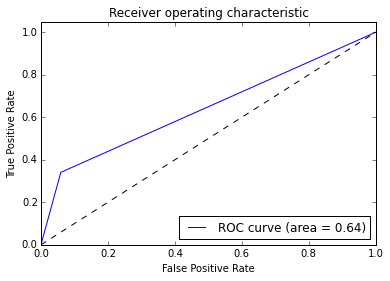

In [86]:
plot_roc(testing_y,pre)

In [152]:
auc=[]
logit_cv = linear_model.LogisticRegressionCV(penalty='l1',solver='liblinear')
k_fold = cross_validation.KFold(df_all_var.shape[0], n_folds=10,shuffle=True)
for k, (train, test) in enumerate(k_fold):
    training_set,testing_set=df_all_var.iloc[train],df_all_var.iloc[test]
    training_x,training_y=training_set[['sapsii','gender','age_score','sapsii_prob','hr_score','sysbp_score','temp_score','uo_score','bun_score'\
                                        ,'wbc_score','potassium_score','sodium_score','bicarbonate_score','gcs_score','comorbidity_score'\
                                        ,'admissiontype_score','count','avg']].as_matrix(),training_set['expire_flag'].as_matrix()
    testing_x,testing_y=testing_set[['sapsii','gender','age_score','sapsii_prob','hr_score','sysbp_score','temp_score','uo_score','bun_score'\
                                     ,'wbc_score','potassium_score','sodium_score','bicarbonate_score','gcs_score','comorbidity_score'\
                                     ,'admissiontype_score','count','avg']].as_matrix(),testing_set['expire_flag'].as_matrix()
    logit_cv.fit(training_x,training_y)
    pre=logit_cv.predict(testing_x)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc.append(auc_sco)
print np.mean(auc)

0.717152114422


In [153]:
logit_cv.coef_

array([[ 0.11614363, -0.00703506,  0.04072813, -0.91116873, -0.04536708,
        -0.07114205,  0.21039173, -0.01429964,  0.00224839, -0.05048048,
        -0.13626687,  0.04073057, -0.0521328 , -0.07403218,  0.06679548,
        -0.02484105,  0.08764352,  0.05060599]])

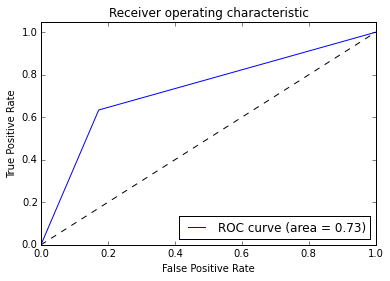

In [89]:
plot_roc(testing_y,pre)

In [54]:
df_all_real=df_all[['subject_id','topic','sapsii','gender','age_score','expire_flag','dead_in_hospital']]
df_all_real.head()

,subject_id,topic,sapsii,gender,age_score,expire_flag,dead_in_hospital
0,3,0,73,1,16,1,0
1,4,1,35,0,7,0,0
2,6,2,24,0,12,0,0
3,9,3,22,1,7,1,1
4,11,4,25,0,7,1,0


## NMF topic modeling used

In [148]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier

auc,auc1,auc2=[],[],[]
kf = KFold(df_all_var.shape[0], n_folds=10,shuffle=True)
for train, test in kf:
    training_set,testing_set=df_all_var.iloc[train],df_all_var.iloc[test]
    training_x,training_y=np.hstack((np.array(nmf_topic_vec[list(training_set['topic']),]),training_set[['sapsii','gender','age_score','sapsii_prob','hr_score','sysbp_score','temp_score','uo_score','bun_score'\
                                        ,'wbc_score','potassium_score','sodium_score','bicarbonate_score','gcs_score','comorbidity_score'\
                                        ,'admissiontype_score']].as_matrix())),training_set['expire_flag'].as_matrix()
    testing_x,testing_y=np.hstack((np.array(nmf_topic_vec[list(testing_set['topic']),]),testing_set[['sapsii','gender','age_score','sapsii_prob','hr_score','sysbp_score','temp_score','uo_score','bun_score'\
                                        ,'wbc_score','potassium_score','sodium_score','bicarbonate_score','gcs_score','comorbidity_score'\
                                        ,'admissiontype_score']].as_matrix())),testing_set['expire_flag'].as_matrix()
    clf = svm.SVC(C=1,gamma=0.1)
    clf.fit(training_x,training_y)
    pre = clf.predict(testing_x)
    clf1=GradientBoostingClassifier(n_estimators=10)
    clf1.fit(training_x,training_y)
    pre1 = clf1.predict(testing_x)
    clf2=RandomForestClassifier(max_depth=30, n_estimators=10)
    clf2.fit(training_x,training_y)
    pre2 = clf2.predict(testing_x)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc_sco1=metrics.roc_auc_score(testing_y,pre1)
    auc_sco2=metrics.roc_auc_score(testing_y,pre2)
    auc.append(auc_sco)
    auc1.append(auc_sco1)
    auc2.append(auc_sco2)
print np.mean(auc),np.mean(auc1),np.mean(auc2)

0.747066578846 0.725449072344 0.739059996165


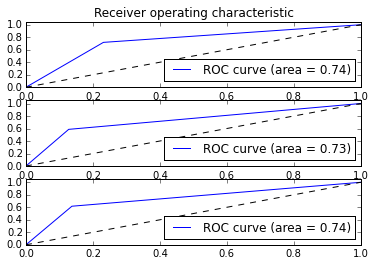

In [149]:
plt.subplot(311)
fpr, tpr, _ = metrics.roc_curve(testing_y,pre)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.subplot(312)
fpr, tpr, _ = metrics.roc_curve(testing_y,pre1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.subplot(313)
fpr, tpr, _ = metrics.roc_curve(testing_y,pre2)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

In [146]:
auc,auc1,auc2=[],[],[]
for train, test in kf:
    training_set,testing_set=df_all_var.iloc[train],df_all_var.iloc[test]
    training_x,training_y=np.hstack((np.array(nmf_topic_vec[list(training_set['topic']),]),training_set[['sapsii','gender','age_score','sapsii_prob','hr_score','sysbp_score','temp_score','uo_score','bun_score'\
                                        ,'wbc_score','potassium_score','sodium_score','bicarbonate_score','gcs_score','comorbidity_score'\
                                        ,'admissiontype_score']].as_matrix())),training_set['dead_in_hospital'].as_matrix()
    testing_x,testing_y=np.hstack((np.array(nmf_topic_vec[list(testing_set['topic']),]),testing_set[['sapsii','gender','age_score','sapsii_prob','hr_score','sysbp_score','temp_score','uo_score','bun_score'\
                                        ,'wbc_score','potassium_score','sodium_score','bicarbonate_score','gcs_score','comorbidity_score'\
                                        ,'admissiontype_score']].as_matrix())),testing_set['dead_in_hospital'].as_matrix()
    clf = svm.SVC(C=1,gamma=0.1)
    clf.fit(training_x,training_y)
    pre = clf.predict(testing_x)
    clf1=GradientBoostingClassifier(n_estimators=10)
    clf1.fit(training_x,training_y)
    pre1 = clf1.predict(testing_x)
    clf2=RandomForestClassifier(max_depth=30, n_estimators=10)
    clf2.fit(training_x,training_y)
    pre2 = clf2.predict(testing_x)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc_sco1=metrics.roc_auc_score(testing_y,pre1)
    auc_sco2=metrics.roc_auc_score(testing_y,pre2)
    auc.append(auc_sco)
    auc1.append(auc_sco1)
    auc2.append(auc_sco2)
print np.mean(auc),np.mean(auc1),np.mean(auc2)

0.528170409021 0.57475093545 0.666322233965


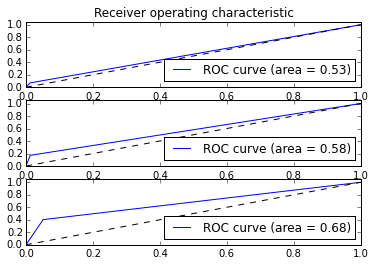

In [147]:
plt.subplot(311)
fpr, tpr, _ = metrics.roc_curve(testing_y,pre)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.subplot(312)
fpr, tpr, _ = metrics.roc_curve(testing_y,pre1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.subplot(313)
fpr, tpr, _ = metrics.roc_curve(testing_y,pre2)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

In [137]:
auc,auc1,auc2=[],[],[]
kf = KFold(df_all_var.shape[0], n_folds=10,shuffle=True)
for train, test in kf:
    training_set,testing_set=df_all_var.iloc[train],df_all_var.iloc[test]
    training_x,training_y=training_set[['sapsii','gender','age_score','sapsii_prob','hr_score','sysbp_score','temp_score','uo_score','bun_score'\
                                        ,'wbc_score','potassium_score','sodium_score','bicarbonate_score','gcs_score','comorbidity_score'\
                                        ,'admissiontype_score','count','avg']].as_matrix(),training_set['dead_in_hospital'].as_matrix()
    testing_x,testing_y=testing_set[['sapsii','gender','age_score','sapsii_prob','hr_score','sysbp_score','temp_score','uo_score','bun_score'\
                                        ,'wbc_score','potassium_score','sodium_score','bicarbonate_score','gcs_score','comorbidity_score'\
                                        ,'admissiontype_score','count','avg']].as_matrix(),testing_set['dead_in_hospital'].as_matrix()
    clf = svm.SVC(C=1,gamma=0.1)
    clf.fit(training_x,training_y)
    pre = clf.predict(testing_x)
    clf1=GradientBoostingClassifier(n_estimators=10)
    clf1.fit(training_x,training_y)
    pre1 = clf1.predict(testing_x)
    clf2=RandomForestClassifier(max_depth=30, n_estimators=10)
    clf2.fit(training_x,training_y)
    pre2 = clf2.predict(testing_x)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc_sco1=metrics.roc_auc_score(testing_y,pre1)
    auc_sco2=metrics.roc_auc_score(testing_y,pre2)
    auc.append(auc_sco)
    auc1.append(auc_sco1)
    auc2.append(auc_sco2)
print np.mean(auc),np.mean(auc1),np.mean(auc2)

0.579484938551 0.576595777644 0.65134073904


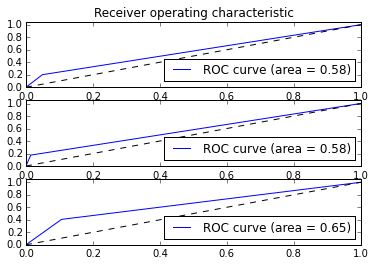

In [145]:
import matplotlib.pyplot as plt
plt.subplot(311)
fpr, tpr, _ = metrics.roc_curve(testing_y,pre)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.subplot(312)
fpr, tpr, _ = metrics.roc_curve(testing_y,pre1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.subplot(313)
fpr, tpr, _ = metrics.roc_curve(testing_y,pre2)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

## LDA topic features used

In [21]:
auc,sco,auc1,auc2=[],[],[],[]
kf = KFold(df_all_real.shape[0], n_folds=10,shuffle=True)
for train, test in kf:
    training_set,testing_set=df_all_real.iloc[train],df_all_real.iloc[test]
    training_x,training_y=np.hstack((np.array(doc_topic[list(training_set['topic']),]),training_set[['sapsii','gender','age_score']]\
                                     .as_matrix())),training_set['expire_flag'].as_matrix()
    testing_x,testing_y=np.hstack((np.array(doc_topic[list(testing_set['topic']),]),testing_set[['sapsii','gender','age_score']]\
                                   .as_matrix())),testing_set['expire_flag'].as_matrix()
    clf = svm.SVC(C=1,gamma=0.1)
    clf.fit(training_x,training_y)
    pre = clf.predict(testing_x)
    clf1=GradientBoostingClassifier(n_estimators=10)
    clf1.fit(training_x,training_y)
    pre1 = clf1.predict(testing_x)
    clf2=RandomForestClassifier(max_depth=30, n_estimators=10)
    clf2.fit(training_x,training_y)
    pre2 = clf2.predict(testing_x)
    score=clf.score(testing_x,testing_y)
    sco.append(score)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc_sco1=metrics.roc_auc_score(testing_y,pre1)
    auc_sco2=metrics.roc_auc_score(testing_y,pre2)
    auc.append(auc_sco)
    auc1.append(auc_sco1)
    auc2.append(auc_sco2)
print np.mean(auc),np.mean(sco),np.mean(auc1),np.mean(auc2)

0.727938517965 0.738943568489 0.713792435847 0.730180274163


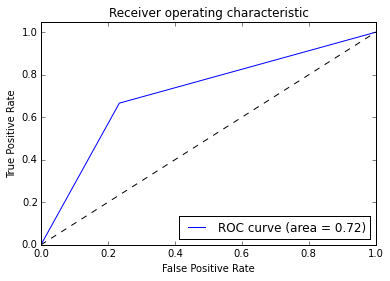

In [91]:
plot_roc(testing_y,pre)

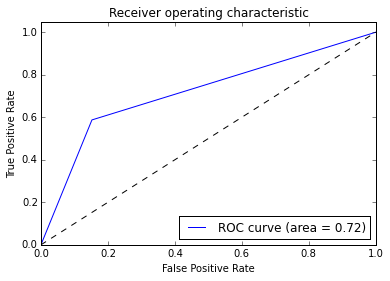

In [23]:
%matplotlib inline
plot_roc(testing_y,pre1)

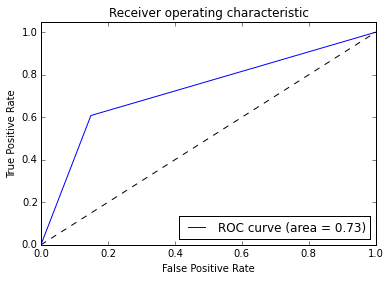

In [24]:
plot_roc(testing_y,pre2)

In [92]:
auc,auc1,auc2=[],[],[]
kf = KFold(df_all_var.shape[0], n_folds=10,shuffle=True)
for train, test in kf:
    training_set,testing_set=df_all_var.iloc[train],df_all_var.iloc[test]
    training_x,training_y=np.hstack((np.array(doc_topic[list(training_set['topic']),]),training_set[['sapsii','gender','age_score','sapsii_prob','hr_score','sysbp_score','temp_score','uo_score','bun_score'\
                                        ,'wbc_score','potassium_score','sodium_score','bicarbonate_score','gcs_score','comorbidity_score'\
                                        ,'admissiontype_score']].as_matrix())),training_set['expire_flag'].as_matrix()
    testing_x,testing_y=np.hstack((np.array(doc_topic[list(testing_set['topic']),]),testing_set[['sapsii','gender','age_score','sapsii_prob','hr_score','sysbp_score','temp_score','uo_score','bun_score'\
                                        ,'wbc_score','potassium_score','sodium_score','bicarbonate_score','gcs_score','comorbidity_score'\
                                        ,'admissiontype_score']].as_matrix())),testing_set['expire_flag'].as_matrix()
    clf = svm.SVC(C=1,gamma=0.1)
    clf.fit(training_x,training_y)
    pre = clf.predict(testing_x)
    clf1=GradientBoostingClassifier(n_estimators=10)
    clf1.fit(training_x,training_y)
    pre1 = clf1.predict(testing_x)
    clf2=RandomForestClassifier(max_depth=30, n_estimators=10)
    clf2.fit(training_x,training_y)
    pre2 = clf2.predict(testing_x)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc_sco1=metrics.roc_auc_score(testing_y,pre1)
    auc_sco2=metrics.roc_auc_score(testing_y,pre2)
    auc.append(auc_sco)
    auc1.append(auc_sco1)
    auc2.append(auc_sco2)
print np.mean(auc),np.mean(auc1),np.mean(auc2)

0.717554120074 0.716133362513 0.734233117334


In [55]:
auc,auc1,auc2=[],[],[]
kf = KFold(df_all_real.shape[0], n_folds=10,shuffle=True)
for train, test in kf:
    training_set,testing_set=df_all_real.iloc[train],df_all_real.iloc[test]
    training_x,training_y=np.hstack((np.array(doc_topic[list(training_set['topic']),]),training_set[['sapsii','gender','age_score']]\
                                     .as_matrix())),training_set['dead_in_hospital'].as_matrix()
    testing_x,testing_y=np.hstack((np.array(doc_topic[list(testing_set['topic']),]),testing_set[['sapsii','gender','age_score']]\
                                   .as_matrix())),testing_set['dead_in_hospital'].as_matrix()
    clf = svm.SVC(C=1,gamma=0.1)
    clf.fit(training_x,training_y)
    pre = clf.predict(testing_x)
    clf1=GradientBoostingClassifier(n_estimators=10)
    clf1.fit(training_x,training_y)
    pre1 = clf1.predict(testing_x)
    clf2=RandomForestClassifier(max_depth=30, n_estimators=10)
    clf2.fit(training_x,training_y)
    pre2 = clf2.predict(testing_x)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc_sco1=metrics.roc_auc_score(testing_y,pre1)
    auc_sco2=metrics.roc_auc_score(testing_y,pre2)
    auc.append(auc_sco)
    auc1.append(auc_sco1)
    auc2.append(auc_sco2)
print np.mean(auc),np.mean(auc1),np.mean(auc2)

0.626258308762 0.571216403785 0.660795386631


In [88]:
auc,sco=[],[]
kf = KFold(df_all_real.shape[0], n_folds=10,shuffle=True)
for train, test in kf:
    training_set,testing_set=df_all_real.iloc[train],df_all_real.iloc[test]
    training_x,training_y=training_set[['sapsii','gender','age_score']].as_matrix(),training_set['expire_flag'].as_matrix()
    testing_x,testing_y=testing_set[['sapsii','gender','age_score']].as_matrix(),testing_set['expire_flag'].as_matrix()
    clf = svm.SVC(C=1,gamma=0.1)
    clf.fit(training_x,training_y)
    pre = clf.predict(testing_x)
    score=clf.score(testing_x,testing_y)
    sco.append(score)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc.append(auc_sco)
print np.mean(auc),np.mean(sco)

0.708624138813 0.717930476199


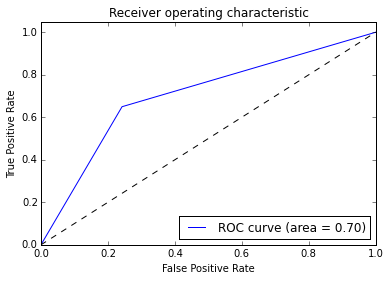

In [89]:
plot_roc(testing_y,pre)

In [20]:
auc,sco,auc1,auc2=[],[],[],[]
kf = KFold(df_all_real.shape[0], n_folds=10,shuffle=True)
for train, test in kf:
    training_set,testing_set=df_all_real.iloc[train],df_all_real.iloc[test]
    training_x,training_y=np.array(doc_topic[list(training_set['topic']),]),training_set['expire_flag'].as_matrix()
    testing_x,testing_y=np.array(doc_topic[list(testing_set['topic']),]),testing_set['expire_flag'].as_matrix()
    clf = svm.SVC(C=1,gamma=0.1)
    clf.fit(training_x,training_y)
    pre = clf.predict(testing_x)
    clf1=GradientBoostingClassifier(n_estimators=10)
    clf1.fit(training_x,training_y)
    pre1 = clf1.predict(testing_x)
    clf2=RandomForestClassifier(max_depth=30, n_estimators=10)
    clf2.fit(training_x,training_y)
    pre2 = clf2.predict(testing_x)
    score=clf.score(testing_x,testing_y)
    sco.append(score)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc_sco1=metrics.roc_auc_score(testing_y,pre1)
    auc_sco2=metrics.roc_auc_score(testing_y,pre2)
    auc.append(auc_sco)
    auc1.append(auc_sco1)
    auc2.append(auc_sco2)
print np.mean(auc),np.mean(sco),np.mean(auc1),np.mean(auc2)

0.687532970348 0.718558940094 0.625680793897 0.677047158857


In [154]:
auc,auc1,auc2=[],[],[]
for train, test in kf:
    training_set,testing_set=df_all_real.iloc[train],df_all_real.iloc[test]
    training_x,training_y=np.array(doc_topic[list(training_set['topic']),]),training_set['dead_in_hospital'].as_matrix()
    testing_x,testing_y=np.array(doc_topic[list(testing_set['topic']),]),testing_set['dead_in_hospital'].as_matrix()
    clf = svm.SVC(C=1,gamma=0.1)
    clf.fit(training_x,training_y)
    pre = clf.predict(testing_x)
    clf1=GradientBoostingClassifier(n_estimators=10)
    clf1.fit(training_x,training_y)
    pre1 = clf1.predict(testing_x)
    clf2=RandomForestClassifier(max_depth=30, n_estimators=10)
    clf2.fit(training_x,training_y)
    pre2 = clf2.predict(testing_x)
    auc_sco=metrics.roc_auc_score(testing_y,pre)
    auc_sco1=metrics.roc_auc_score(testing_y,pre1)
    auc_sco2=metrics.roc_auc_score(testing_y,pre2)
    auc.append(auc_sco)
    auc1.append(auc_sco1)
    auc2.append(auc_sco2)
print np.mean(auc),np.mean(auc1),np.mean(auc2)

0.541570268733 0.523386737669 0.625996742019


In [82]:
x=np.hstack((np.array(doc_topic),df_all_real[['sapsii','gender','age_score']][:doc_topic.shape[0]].as_matrix()))
y=df_all_real['expire_flag'][:doc_topic.shape[0]].as_matrix()
y

array([1, 0, 0, ..., 1, 1, 0], dtype=int64)

## Hyper Parameter Tuning

In [83]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV


C_range = [1e-2, 1, 1e2]
gamma_range = [1e-1, 1, 1e1]
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(y, n_iter=10, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(x, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1, 'gamma': 0.1} with a score of 0.72


In [92]:
csvfile.close()